# Benchmark Analysis - H5

In [60]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [61]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [62]:
matplotlib.style.use('seaborn-v0_8')  

In [63]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [64]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [65]:
plot_save_dir = './plots/h5'

## Utils 

In [66]:
def get_path(*entries):
    return os.path.join(*entries)

In [67]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [68]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [69]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [70]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [71]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [72]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [73]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [74]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(f'{root_dir}/{compiler_location}/DEFAULT/{bench_name}_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    print(seq_base)

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H5
> Parallel stl backends use special parallelism techniques for linear algorithms, which have no clear reference
> implementation, leading to significant differences in terms of performance and their strong scaling properties.


## `b5_1_find_std::vector<int>_first_entry_par`

In [75]:
benchmark_name = "b5_1_find_std::vector<int>_first_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_first_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [76]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_first_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_first_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,6133.69,4,49535.4
1,12458.50,8,45414.3
2,17749.60,16,42088.2
3,22219.20,32,45344.8
4,25757.50,64,48028.2
5,28652.60,128,48131.7
6,30021.60,256,47301.7
7,31851.10,512,47227.5
8,34924.10,1024,47088.9
9,37871.60,2048,47328.7


### Strong Scaling - `b5_1_find_std::vector<int>_first_entry`
 
2^26 fixed input size with threads 1-64

In [77]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_first_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_first_entry_strong_scaling_merged

0                                               name  real_time  cpu_time  \
0  GCC_TBB_b5_1_find_std::vector<int>_first_entry...    265.947   267.842   

0 time_unit         n   median    stddev  Compiler  
0        ns  67108864  265.947  0.155081  GCC(TBB)  
0                                               name  real_time  cpu_time  \
0  NVHPC_Multicore_b5_1_find_std::vector<int>_fir...    259.363   261.173   

0 time_unit         n   median    stddev  Compiler  
0        ns  67108864  259.363  0.029773  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,0.002527,0.000228
1,2,0.004557,0.000447
2,4,0.006004,0.000850
3,8,0.006038,0.001467
4,16,0.006004,0.002188
5,32,0.006345,0.002936
6,64,0.005987,0.002907


In [78]:
## efficiency graph

b5_1_find_std_vector_int_first_entry_efficiency = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_first_entry_efficiency['threads']



b5_1_find_std_vector_int_first_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.002527,0.000228
1,2,0.002278,0.000223
2,4,0.001501,0.000212
3,8,0.000755,0.000183
4,16,0.000375,0.000137
5,32,0.000198,0.000092
6,64,0.000094,0.000045


### Plots

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/1785937751.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


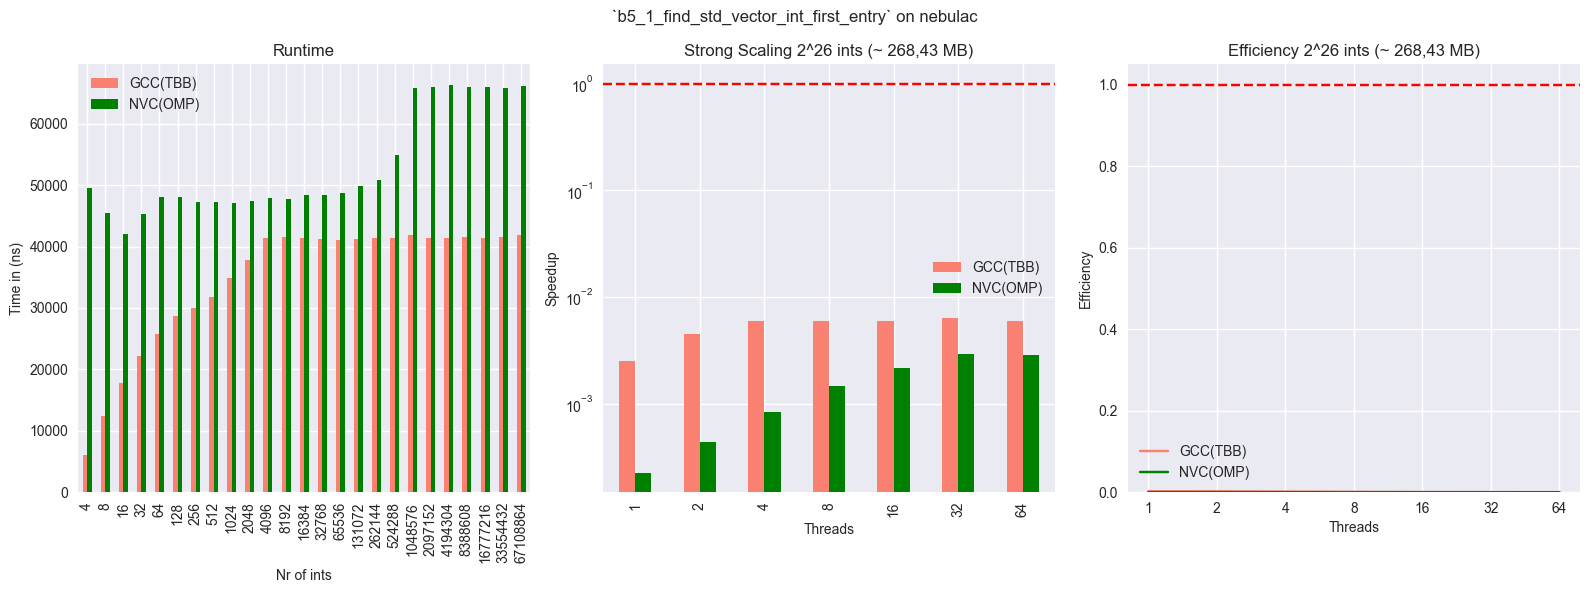

In [79]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_first_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b5_1_find_std_vector_int_first_entry_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b5_1_find_std_vector_int_first_entry` on nebulac")

fig.tight_layout()

plot("`b5_1_find_std_vector_int_first_entry` nebulac")

## `b5_1_find_std::vector<int>_last_entry_par`

In [80]:
benchmark_name = "b5_1_find_std::vector<int>_last_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_last_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [81]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_last_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_last_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,5859.11,4,90363.2
1,9936.83,8,50090.8
2,14349.90,16,39914.4
3,19115.10,32,42494.7
4,23028.90,64,42380.3
5,25380.70,128,41829.0
6,27394.00,256,41947.9
7,31264.50,512,42490.8
8,34269.40,1024,42492.8
9,37616.90,2048,42621.7


### Strong Scaling - `b5_1_find_std::vector<int>_last_entry`
 
2^26 fixed input size with threads 1-64

In [82]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_last_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_last_entry_strong_scaling_merged

0                                               name   real_time    cpu_time  \
0  GCC_TBB_b5_1_find_std::vector<int>_last_entry_seq  21673700.0  21676000.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  21673700.0  803.424  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_1_find_std::vector<int>_las...  22638400.0  22640500.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  22638400.0  4018.23  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,1.001826,0.281895
1,2,1.918264,0.555494
2,4,2.686675,1.032199
3,8,1.545516,1.006518
4,16,2.278154,1.118492
5,32,2.283904,1.153126
6,64,2.221458,0.994889


In [83]:
## efficiency graph

b5_1_find_std_vector_int_last_entry_efficiency = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_last_entry_efficiency['threads']



b5_1_find_std_vector_int_last_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.001826,0.281895
1,2,0.959132,0.277747
2,4,0.671669,0.258050
3,8,0.193190,0.125815
4,16,0.142385,0.069906
5,32,0.071372,0.036035
6,64,0.034710,0.015545


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/3271728666.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


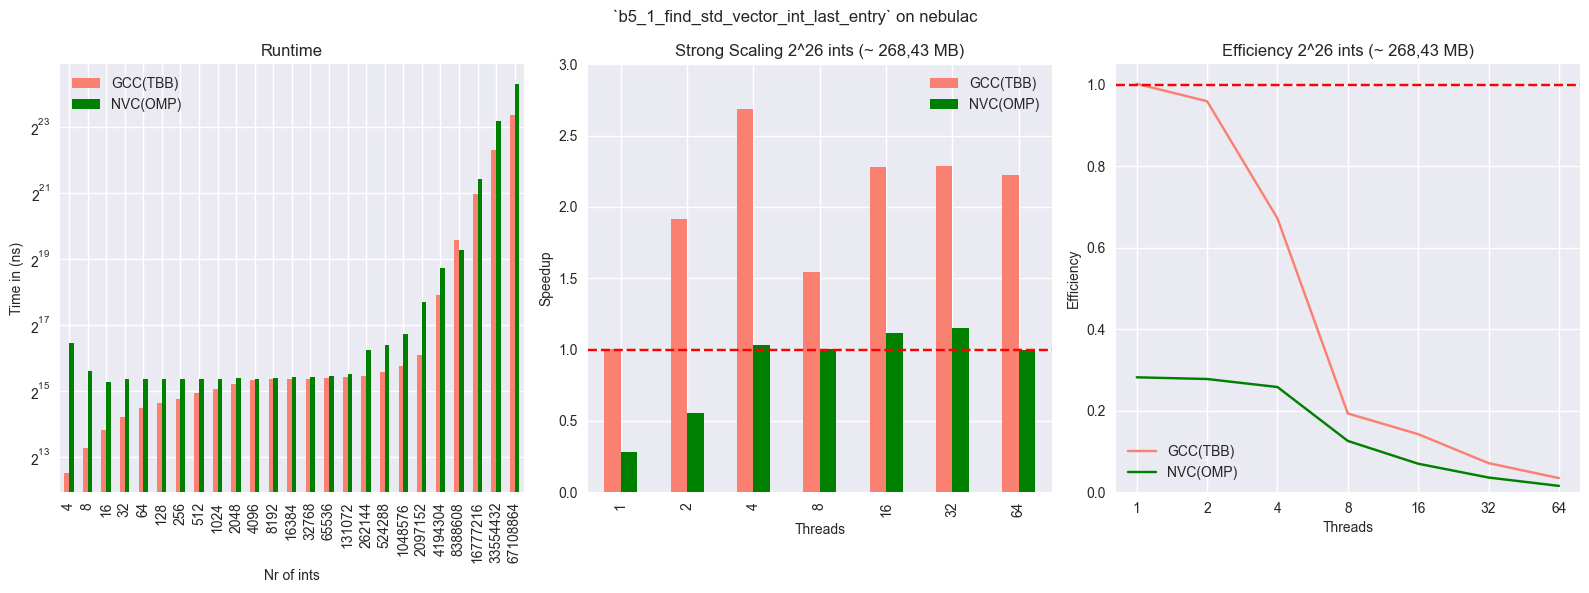

In [84]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_last_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_last_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b5_1_find_std_vector_int_last_entry` on nebulac")

fig.tight_layout()

plot("`b5_1_find_std_vector_int_last_entry` nebulac")

## `b5_1_find_std::vector<int>_non_existing_entry_par`

In [85]:
benchmark_name = "b5_1_find_std::vector<int>_non_existing_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_non_existing_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [86]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_non_existing_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_non_existing_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,8605.87,4,59390.5
1,10057.70,8,51873.2
2,15020.40,16,46566.6
3,19739.90,32,47305.4
4,23764.80,64,48610.6
5,26411.70,128,48721.3
6,27941.30,256,49104.6
7,30528.30,512,48897.1
8,33542.50,1024,48986.6
9,37344.40,2048,49042.8


### Strong Scaling - `b5_1_find_std::vector<int>_non_existing_entry`
 
2^26 fixed input size with threads 1-64

In [87]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged

0                                               name   real_time    cpu_time  \
0  GCC_TBB_b5_1_find_std::vector<int>_non_existin...  20491300.0  20492500.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  20491300.0  10557.0  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_1_find_std::vector<int>_non...  23077900.0  23080100.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  23077900.0  5241.66  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,1.062171,0.315559
1,2,1.943335,0.613461
2,4,2.432433,1.112891
3,8,2.126207,1.117487
4,16,1.707054,1.227959
5,32,1.973144,1.166240
6,64,1.882769,0.867639


In [88]:
## efficiency graph

b5_1_find_std_vector_int_non_existing_entry_efficiency = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_non_existing_entry_efficiency['threads']



b5_1_find_std_vector_int_non_existing_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.062171,0.315559
1,2,0.971667,0.306730
2,4,0.608108,0.278223
3,8,0.265776,0.139686
4,16,0.106691,0.076747
5,32,0.061661,0.036445
6,64,0.029418,0.013557


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/2019396929.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


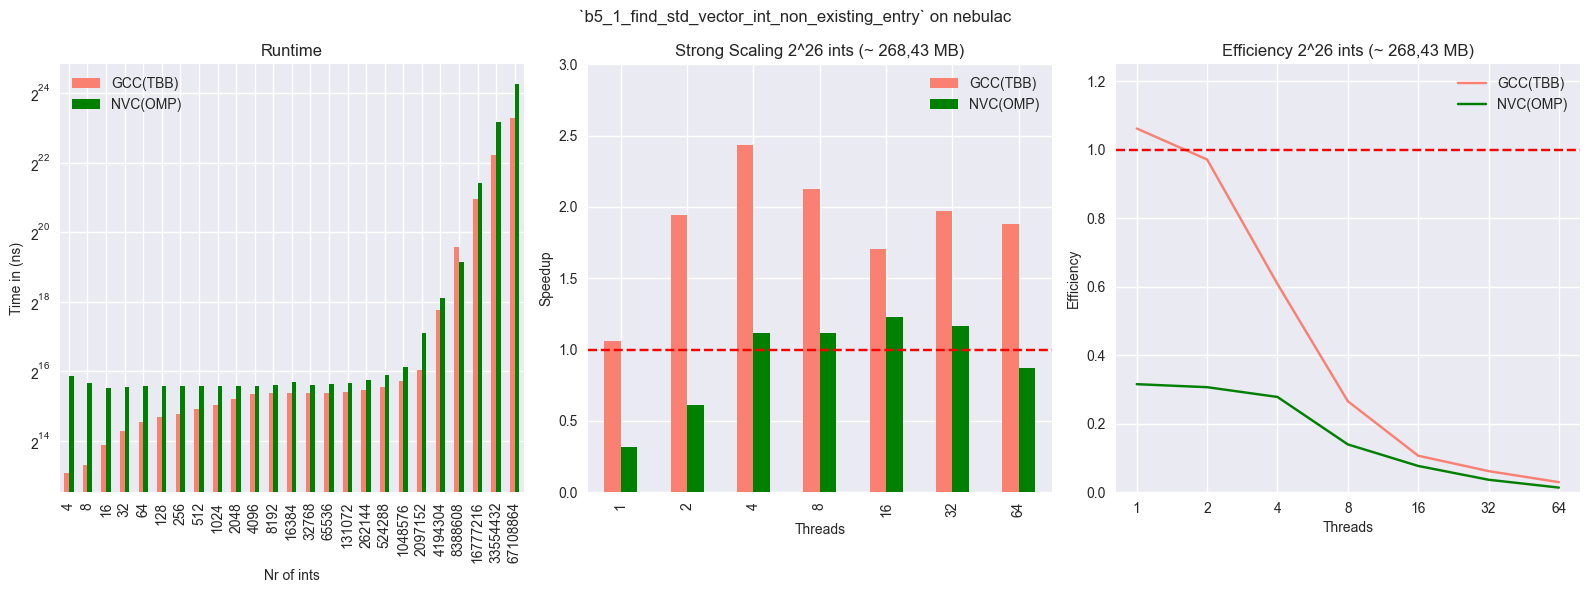

In [89]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_non_existing_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_non_existing_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b5_1_find_std_vector_int_non_existing_entry` on nebulac")

fig.tight_layout()

plot("`b5_1_find_std_vector_int_non_existing_entry` nebulac")

## `b5_2_partition_par`

In [90]:
benchmark_name = "b5_2_partition"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_2_partition_par`

Check how the runtime without constraining the threads develops with increasing input size

In [91]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_2_partition_time_merged = pd.merge(*data, on='n')

b5_2_partition_time_merged

,GCC(TBB),n,NVC(OMP)
0,8121.01,4,3.508180e+02
1,13058.70,8,4.217580e+02
2,18930.70,16,5.628330e+02
3,24050.10,32,8.437070e+02
4,28159.50,64,1.405260e+03
5,30550.90,128,2.527520e+03
6,34987.80,256,4.772950e+03
7,39943.30,512,9.263710e+03
8,46186.70,1024,1.824650e+04
9,53832.20,2048,3.620300e+04


### Strong Scaling - `b5_2_partition_strong_par`
 
2^26 fixed input size with threads 1-64

In [92]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_2_partition_strong_scaling_merged = pd.merge(*data, on='threads')

b5_2_partition_strong_scaling_merged

0                        name     real_time      cpu_time time_unit         n  \
0  GCC_TBB_b5_2_partition_seq  1.281790e+09  1.281730e+09        ns  67108864   

0        median   stddev  Compiler  
0  1.281790e+09  89757.0  GCC(TBB)  
0                                name     real_time      cpu_time time_unit  \
0  NVHPC_Multicore_b5_2_partition_seq  1.208400e+09  1.208370e+09        ns   

0         n        median     stddev  Compiler  
0  67108864  1.208400e+09  1340500.0  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,0.996812,1.030039
1,2,1.995038,1.030091
2,4,3.976022,1.030074
3,8,7.161438,1.030750
4,16,14.503693,1.030944
5,32,27.437453,1.029819
6,64,52.980759,1.030074


In [93]:
## efficiency graph

b5_2_partition_efficiency = b5_2_partition_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_2_partition_efficiency[f'{compiler_name}'] = b5_2_partition_efficiency[f'{compiler_name}'] / b5_2_partition_efficiency['threads']



b5_2_partition_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.996812,1.030039
1,2,0.997519,0.515046
2,4,0.994006,0.257518
3,8,0.895180,0.128844
4,16,0.906481,0.064434
5,32,0.857420,0.032182
6,64,0.827824,0.016095


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/3104984362.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


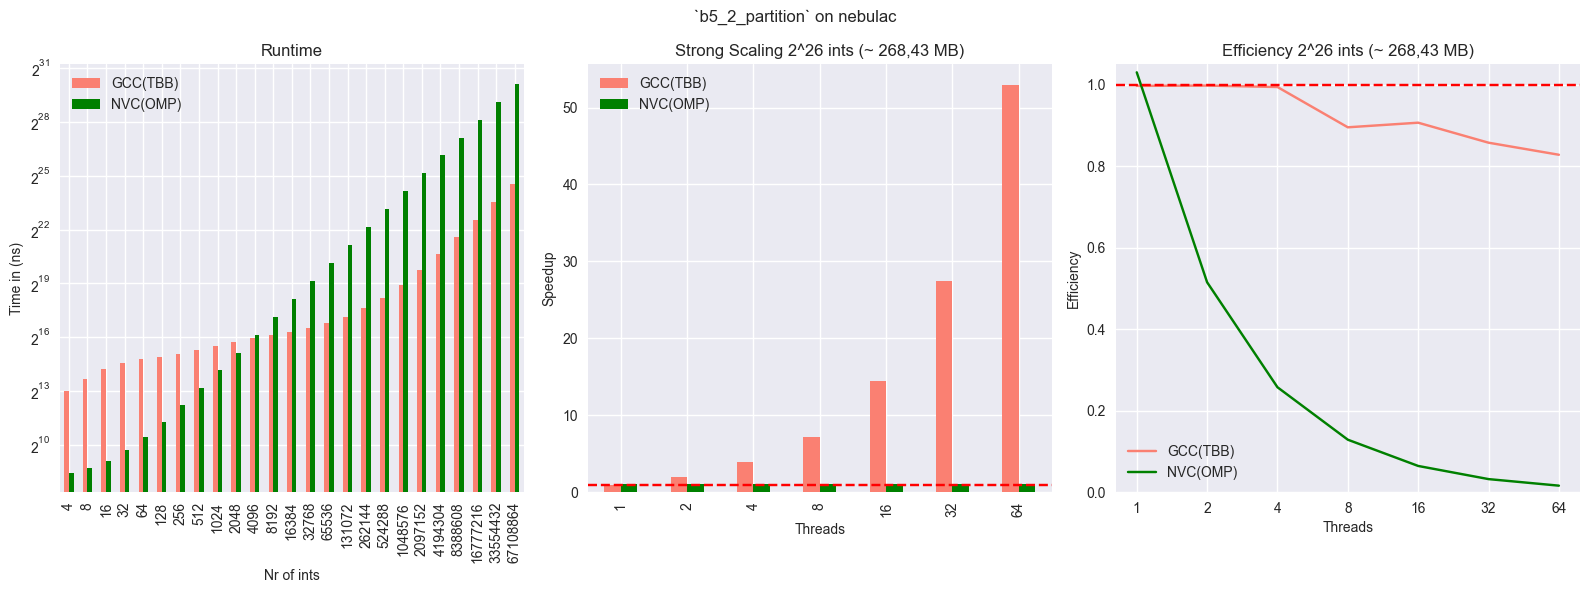

In [94]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_2_partition_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_2_partition_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_2_partition_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_2_partition` on nebulac")

fig.tight_layout()

plot("`b5_2_partition` nebulac")

## `b5_3_unique_copy_default_par`

In [95]:
benchmark_name = "b5_3_unique_copy_default"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_3_unique_copy_default_par`

Check how the runtime without constraining the threads develops with increasing input size

In [96]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_3_unique_copy_default_time_merged = pd.merge(*data, on='n')

b5_3_unique_copy_default_time_merged

,GCC(TBB),n,NVC(OMP)
0,20700.9,4,25650.9
1,39805.7,8,22678.8
2,57667.7,16,22054.5
3,69887.1,32,22696.1
4,81931.4,64,24652.0
5,90638.5,128,23726.7
6,97227.9,256,23345.0
7,93075.8,512,25918.0
8,88947.3,1024,25530.3
9,88796.8,2048,28304.9


### Strong Scaling - `b5_3_unique_copy_default_strong_par`
 
2^26 fixed input size with threads 1-64

In [97]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_3_unique_copy_default_strong_scaling_merged = pd.merge(*data, on='threads')

b5_3_unique_copy_default_strong_scaling_merged

0                                  name   real_time    cpu_time time_unit  \
0  GCC_TBB_b5_3_unique_copy_default_seq  67911100.0  67912200.0        ns   

0         n      median   stddev  Compiler  
0  67108864  67911100.0  6854.13  GCC(TBB)  
0                                          name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_3_unique_copy_default_seq  24289100.0  24289500.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  24289100.0  2692.31  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,0.916354,0.060031
1,2,1.645360,0.102754
2,4,2.929349,0.161924
3,8,3.708172,0.201175
4,16,3.691202,0.246262
5,32,3.827228,0.262746
6,64,3.533687,0.239876


In [98]:
## efficiency graph

b5_3_unique_copy_default_efficiency = b5_3_unique_copy_default_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_3_unique_copy_default_efficiency[f'{compiler_name}'] = b5_3_unique_copy_default_efficiency[f'{compiler_name}'] / b5_3_unique_copy_default_efficiency['threads']



b5_3_unique_copy_default_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.916354,0.060031
1,2,0.822680,0.051377
2,4,0.732337,0.040481
3,8,0.463522,0.025147
4,16,0.230700,0.015391
5,32,0.119601,0.008211
6,64,0.055214,0.003748


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/3892902762.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


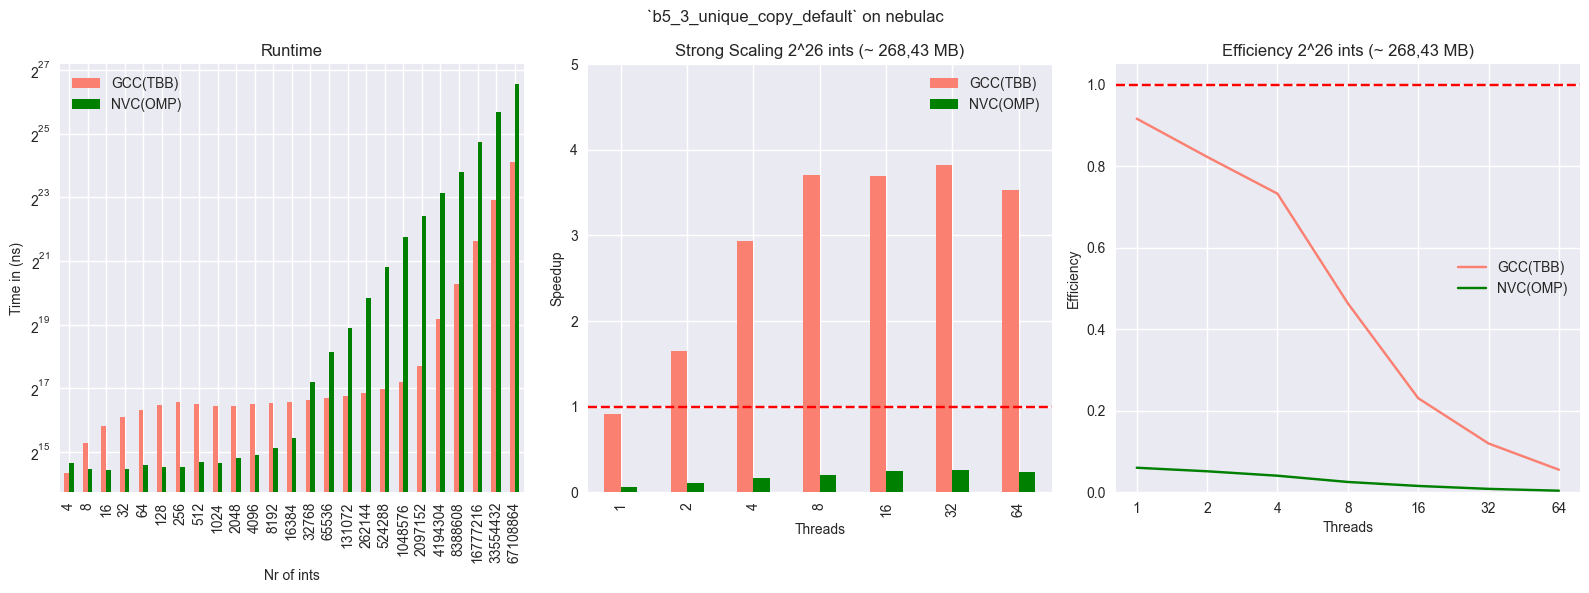

In [99]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_3_unique_copy_default_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_3_unique_copy_default_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,5)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_3_unique_copy_default_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_3_unique_copy_default` on nebulac")

fig.tight_layout()

plot("`b5_3_unique_copy_default` nebulac")

## `b5_4_minmax_element_all_equal_par`

In [100]:
benchmark_name = "b5_4_minmax_element_all_equal"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_all_equal_par`

Check how the runtime without constraining the threads develops with increasing input size

In [101]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_all_equal_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_all_equal_time_merged

,GCC(TBB),n,NVC(OMP)
0,5549.86,4,66621.6
1,10476.90,8,45555.7
2,16491.20,16,43761.8
3,22117.10,32,43947.2
4,26424.30,64,43299.2
5,28688.00,128,43827.7
6,32194.90,256,43517.8
7,36362.40,512,40652.2
8,40413.90,1024,40915.5
9,44602.80,2048,42974.7


### Strong Scaling - `b5_4_minmax_element_all_equal_strong_par`
 
2^26 fixed input size with threads 1-64

In [102]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_all_equal_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_all_equal_strong_scaling_merged

0                                       name   real_time    cpu_time  \
0  GCC_TBB_b5_4_minmax_element_all_equal_seq  78886600.0  78886300.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78886600.0  23603.4  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_4_minmax_element_all_equal_seq  78835100.0  78835200.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78835100.0  20856.8  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,2.202374,0.184940
1,2,4.452619,0.369592
2,4,6.081533,0.726524
3,8,5.182169,1.243528
4,16,8.083944,2.919354
5,32,8.349856,3.773694
6,64,7.251873,3.718795


In [103]:
## efficiency graph

b5_4_minmax_element_all_equal_efficiency = b5_4_minmax_element_all_equal_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] = b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] / b5_4_minmax_element_all_equal_efficiency['threads']



b5_4_minmax_element_all_equal_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.202374,0.184940
1,2,2.226309,0.184796
2,4,1.520383,0.181631
3,8,0.647771,0.155441
4,16,0.505246,0.182460
5,32,0.260933,0.117928
6,64,0.113311,0.058106


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/3776077154.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


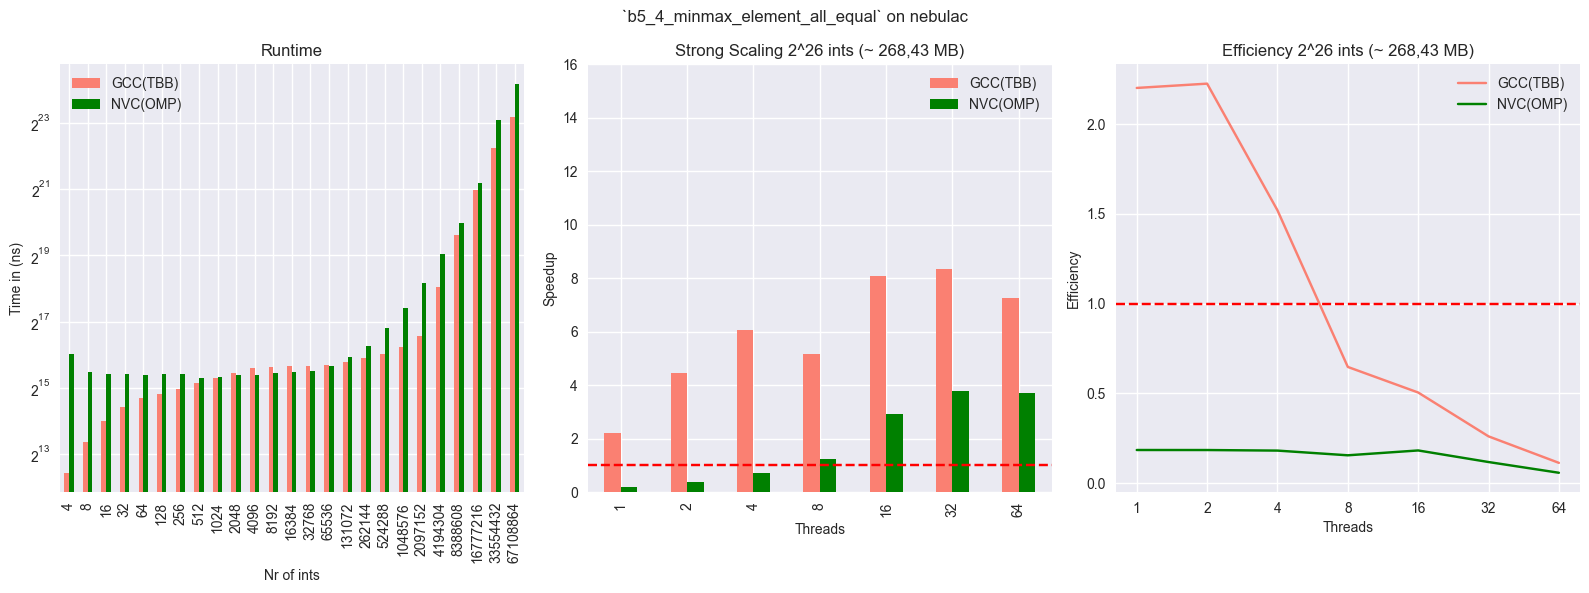

In [104]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_all_equal_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_all_equal_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylim(0,16)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_all_equal_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_4_minmax_element_all_equal` on nebulac")

fig.tight_layout()

plot("`b5_4_minmax_element_all_equal` nebulac")

## `b5_4_minmax_element_increasing_par`

In [105]:
benchmark_name = "b5_4_minmax_element_increasing"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_increasing_par`

Check how the runtime without constraining the threads develops with increasing input size

In [106]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_increasing_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_increasing_time_merged

,GCC(TBB),n,NVC(OMP)
0,5102.52,4,67239.0
1,10816.40,8,47374.9
2,17025.60,16,47227.8
3,22743.80,32,53529.7
4,27342.00,64,49421.6
5,29877.70,128,49143.1
6,33271.90,256,47890.2
7,37570.60,512,47614.5
8,42456.40,1024,45301.2
9,47547.70,2048,47140.2


### Strong Scaling - `b5_4_minmax_element_increasing_strong_par`
 
2^26 fixed input size with threads 1-64

In [107]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_increasing_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_increasing_strong_scaling_merged

0                                        name   real_time    cpu_time  \
0  GCC_TBB_b5_4_minmax_element_increasing_seq  78893400.0  78894900.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78893400.0  31644.1  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_4_minmax_element_increasing...  78823400.0  78824700.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78823400.0  33283.1  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,2.199389,0.195156
1,2,4.392704,0.389898
2,4,8.410290,0.772657
3,8,5.613710,1.493433
4,16,7.955811,3.084208
5,32,8.076315,3.773892
6,64,7.987490,4.337057


In [108]:
## efficiency graph

b5_4_minmax_element_increasing_efficiency = b5_4_minmax_element_increasing_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] = b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] / b5_4_minmax_element_increasing_efficiency['threads']



b5_4_minmax_element_increasing_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.199389,0.195156
1,2,2.196352,0.194949
2,4,2.102573,0.193164
3,8,0.701714,0.186679
4,16,0.497238,0.192763
5,32,0.252385,0.117934
6,64,0.124805,0.067767


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_74556/145666751.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


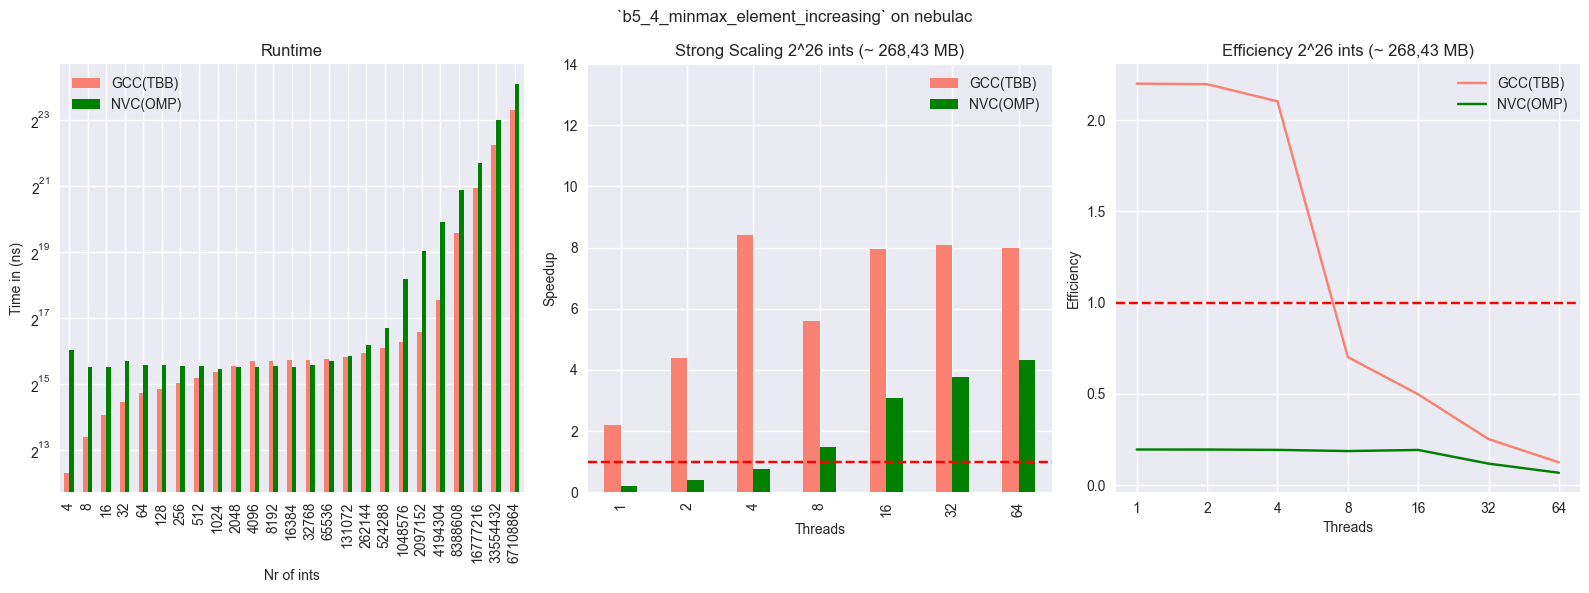

In [109]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_increasing_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_increasing_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,14)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_increasing_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_4_minmax_element_increasing` on nebulac")

fig.tight_layout()

plot("`b5_4_minmax_element_increasing` nebulac")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime 

In [110]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    max_val = max(data_points)
    return len(data_points) / sum([1/(val/max_val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b5_1_first_entry',b5_1_find_std_vector_int_first_entry_time_merged),
    ('b5_1_last_entry',b5_1_find_std_vector_int_last_entry_time_merged),
    ('b5_1_non_existing',b5_1_find_std_vector_int_non_existing_entry_time_merged),

    ('b5_2_partition',b5_2_partition_time_merged),

    ('b5_3_unique_copy',b5_3_unique_copy_default_time_merged),

    ('b5_4_minmax_element_all_equal',b5_4_minmax_element_all_equal_time_merged),
    ('b5_4_minmax_element_increasing',b5_4_minmax_element_increasing_time_merged),
    
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df



,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b5_1_first_entry,41817,66086,0.775085,BAD
1,b5_1_last_entry,10789400,20926500,0.680378,BAD
2,b5_1_non_existing,10241100,20290700,0.670848,BAD
3,b5_2_partition,23912100,1172710000,0.039966,BAD
4,b5_3_unique_copy,18275300,100098000,0.308774,BAD
5,b5_4_minmax_element_all_equal,9570390,19047400,0.668842,BAD
6,b5_4_minmax_element_increasing,10267200,17992900,0.726622,BAD


## Findings for H5

### XXX

### General


### GPU Findings


### Hypothesis Findings


